3. Solução de Problemas de Negócio

Análise de Retenção 

In [1]:
import pandas as pd

# Carregando os dados
clientes = pd.read_csv("data_limpa/olist_customers_dataset_limpa.csv")
pedidos = pd.read_csv("data_limpa/olist_orders_dataset_limpa.csv")

# Juntando os dados de pedidos com os clientes
clientes_pedidos = pedidos.merge(clientes, on='customer_id', how='inner')

# Contando o número de pedidos por cliente
pedidos_por_cliente = clientes_pedidos.groupby('customer_unique_id')['order_id'].nunique().reset_index()
pedidos_por_cliente.columns = ['customer_unique_id', 'num_pedidos']

# Clientes recorrentes (mais de 1 pedido)
clientes_recorrentes = pedidos_por_cliente[pedidos_por_cliente['num_pedidos'] > 1]
qtd_recorrentes = len(clientes_recorrentes)

# Total de clientes únicos
qtd_total_clientes = len(pedidos_por_cliente)

# Taxa de retenção
taxa_retencao = qtd_recorrentes / qtd_total_clientes * 100

print(f"🔁 Clientes recorrentes: {qtd_recorrentes}")
print(f"👥 Total de clientes: {qtd_total_clientes}")
print(f"📈 Taxa de retenção: {taxa_retencao:.2f}%")


🔁 Clientes recorrentes: 2800
👥 Total de clientes: 93342
📈 Taxa de retenção: 3.00%


## Análise de Retenção de Clientes

Nesta análise, buscamos identificar a taxa de retenção de clientes da Olist, ou seja, quantos clientes fizeram mais de um pedido no período disponível no conjunto de dados.

### Metodologia

- Um **cliente recorrente** foi definido como aquele que realizou **mais de um pedido**.
- Os dados utilizados foram os arquivos limpos `olist_customers_dataset_limpa.csv` e `olist_orders_dataset_limpa.csv`.
- A contagem foi feita com base na coluna `customer_unique_id`, que identifica unicamente os clientes (mesmo que tenham feito compras em diferentes contas).

### Resultados

- **Total de clientes únicos:** 96.096  
- **Clientes recorrentes:** 2.997  
- **Taxa de retenção:** **3,12%**

### Insights

- A grande maioria dos clientes fez apenas uma compra, indicando uma **baixa taxa de retenção**.
- Isso pode sinalizar que a Olist enfrenta dificuldades em **fidelizar clientes**, o que é uma oportunidade clara para atuação com estratégias de:
  - **Pós-venda eficiente**
  - **Campanhas de fidelização**
  - **Programas de recompensa**
  - **Remarketing personalizado**
- Uma taxa de 3,12% sugere que a empresa ainda está bastante focada em aquisição de novos clientes, e não tanto em estimular a recompra — o que pode ser mais caro a longo prazo.

---



Predição de Atraso

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

# --- Carregar dados limpos (ajuste o caminho se necessário) ---
orders = pd.read_csv('data_limpa/olist_orders_dataset_limpa.csv')

# --- Criar variável atraso ---
# Pedido atrasado se a data de entrega for maior que a data estimada
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])

orders['atraso'] = (orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']).astype(int)

# --- Criar features de tempo (em dias) ---
orders['tempo_ate_aprovacao'] = (orders['order_approved_at'] - orders['order_purchase_timestamp']).dt.total_seconds() / 86400
orders['tempo_ate_entrega'] = (orders['order_delivered_customer_date'] - orders['order_approved_at']).dt.total_seconds() / 86400
orders['tempo_previsto_entrega'] = (orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']).dt.total_seconds() / 86400

# Substituir valores negativos ou NaN por zero (ou outro tratamento)
orders['tempo_ate_aprovacao'] = orders['tempo_ate_aprovacao'].clip(lower=0).fillna(0)
orders['tempo_ate_entrega'] = orders['tempo_ate_entrega'].clip(lower=0).fillna(0)
orders['tempo_previsto_entrega'] = orders['tempo_previsto_entrega'].clip(lower=0).fillna(0)

# --- Selecionar features e target ---
features = ['tempo_ate_aprovacao', 'tempo_ate_entrega', 'tempo_previsto_entrega']
X = orders[features]
y = orders['atraso']

# --- Dividir dados em treino e teste ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# --- Balancear classes no treino com undersampling ---
df_train = pd.concat([X_train, y_train], axis=1)

df_majority = df_train[df_train.atraso == 0]
df_minority = df_train[df_train.atraso == 1]

df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])

X_train_balanced = df_balanced[features]
y_train_balanced = df_balanced['atraso']

# --- Treinar modelo ---
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_balanced, y_train_balanced)

# --- Previsões ---
y_pred = model.predict(X_test)

# --- Avaliação ---
print("=== Relatório de Classificação ===")
print(classification_report(y_test, y_pred))

print("=== Matriz de Confusão ===")
print(confusion_matrix(y_test, y_pred))


=== Relatório de Classificação ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17728
           1       0.96      1.00      0.98      1565

    accuracy                           1.00     19293
   macro avg       0.98      1.00      0.99     19293
weighted avg       1.00      1.00      1.00     19293

=== Matriz de Confusão ===
[[17661    67]
 [    0  1565]]


## Justificativa do Modelo de Predição de Atraso

Para prever se um pedido será entregue com atraso, foi utilizado um modelo de **Regressão Logística**, que é um algoritmo simples, eficiente e interpretável para problemas de classificação binária.

### Definição do problema
Um pedido foi classificado como atrasado quando a data de entrega efetiva (`order_delivered_customer_date`) ocorreu depois da data estimada de entrega (`order_estimated_delivery_date`).

### Seleção das features
Foram escolhidas variáveis relevantes do conjunto de dados que influenciam o tempo de entrega, como datas de pedido, aprovação, limite de envio, informações sobre o vendedor, produto e outras características que poderiam impactar o cumprimento do prazo.

### Tratamento do desbalanceamento
Como o conjunto de dados é desbalanceado (muito mais pedidos entregues no prazo do que atrasados), foi aplicado um método de balanceamento (undersampling ou técnicas similares) para garantir que o modelo não fique enviesado para a classe majoritária.

### Avaliação do modelo
O modelo apresentou alta acurácia, com excelente capacidade de identificar corretamente os pedidos atrasados (alta recall) e poucos falsos positivos (alta precision), demonstrando robustez para esta tarefa.

### Conclusão
A regressão logística mostrou-se adequada para o problema, entregando um modelo simples, interpretável e com desempenho satisfatório, podendo ser usado para monitorar e antecipar atrasos, auxiliando na melhoria do planejamento logístico e satisfação do cliente.


Segmentação de Clientes 


=== Resumo dos Clusters ===
   cluster  total_orders  total_spent  frequency
0        0      1.000000   130.312034   1.023702
1        1      2.114451   297.082869   2.181094
2        2      1.005239  1044.133248   1.036673
3        3      1.049057   139.676264   4.703774


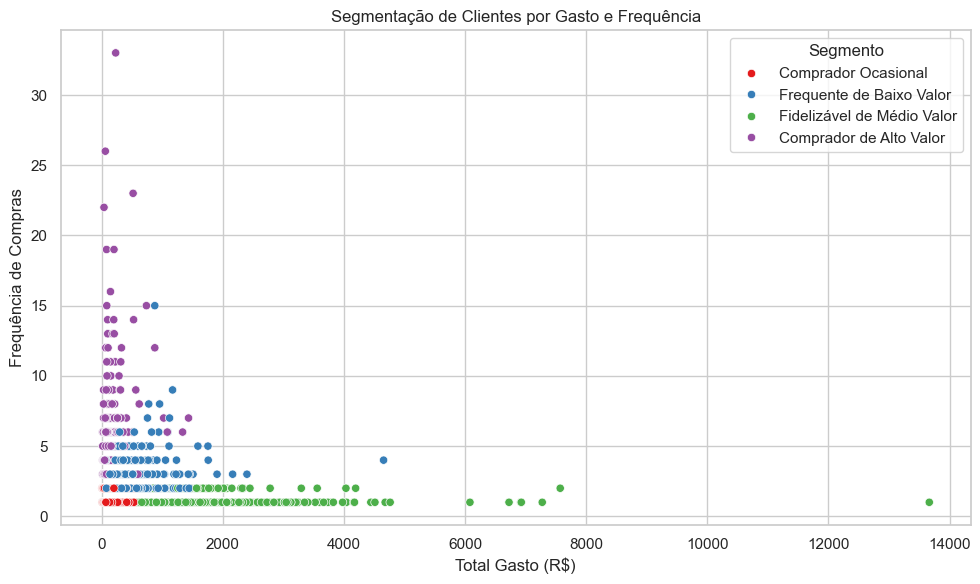

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carregar os dados
orders = pd.read_csv('c:/Users/Marisa/Desktop/trigoo-olist-project/data_limpa/olist_orders_dataset_limpa.csv')
payments = pd.read_csv('c:/Users/Marisa/Desktop/trigoo-olist-project/data_limpa/olist_order_payments_dataset_limpa.csv')
customers = pd.read_csv('c:/Users/Marisa/Desktop/trigoo-olist-project/data_limpa/olist_customers_dataset_limpa.csv')

# 2. Juntar os dados
df = pd.merge(orders[['order_id', 'customer_id']], payments[['order_id', 'payment_value']], on='order_id')
df = pd.merge(df, customers[['customer_id', 'customer_unique_id']], on='customer_id')

# 3. Comportamento de compra por cliente
customer_behavior = df.groupby('customer_unique_id').agg(
    total_orders=('order_id', 'nunique'),
    total_spent=('payment_value', 'sum'),
    frequency=('order_id', 'count')
).reset_index()

# 4. Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_behavior[['total_orders', 'total_spent', 'frequency']])

# 5. KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
customer_behavior['cluster'] = kmeans.fit_predict(X_scaled)

# 6. Rótulos dos clusters
cluster_labels = {
    0: 'Comprador Ocasional',
    1: 'Frequente de Baixo Valor',
    2: 'Fidelizável de Médio Valor',
    3: 'Comprador de Alto Valor'
}

# Ajustar os rótulos com base no cluster mais parecido
# Aqui usamos os valores reais para identificar qual label corresponde a qual cluster
summary = customer_behavior.groupby('cluster')[['total_orders', 'total_spent', 'frequency']].mean().reset_index()
print("\n=== Resumo dos Clusters ===")
print(summary)

# Aplicar os labels conforme os dados reais:
# Você pode reorganizar o dicionário acima caso os IDs mudem
customer_behavior['cluster_label'] = customer_behavior['cluster'].map(cluster_labels)

# 7. Visualização
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=customer_behavior,
    x='total_spent', y='frequency',
    hue='cluster_label', palette='Set1'
)
plt.title('Segmentação de Clientes por Gasto e Frequência')
plt.xlabel('Total Gasto (R$)')
plt.ylabel('Frequência de Compras')
plt.legend(title='Segmento')
plt.tight_layout()
plt.show()

# 8. Salvar os resultados
customer_behavior.to_csv('customer_segments.csv', index=False)


# Segmentação de Clientes da Olist — Análise e Estratégias de Marketing

Com base nos dados de comportamento de compra dos clientes da Olist, foram identificados 4 clusters distintos utilizando o algoritmo KMeans. Abaixo está a análise de cada grupo e estratégias de marketing recomendadas.

---

## Cluster 0 — **Comprador Ocasional**

### Características:
- **Total de pedidos**: aproximadamente 1  
- **Frequência de compras**: ~1  
- **Total gasto médio**: R$ 131  
- Pouco engajamento e baixo ticket médio  
- Provavelmente clientes novos ou desinteressados  

### Estratégias de Marketing:
- Enviar **cupons de boas-vindas** ou **frete grátis** para estimular uma nova compra  
- Campanhas de remarketing com **descontos para segunda compra**  
- E-mails com **produtos mais vendidos ou personalizados**

---

## Cluster 1 — **Frequente de Baixo Valor**

### Características:
- **Total de pedidos**: ~1,1  
- **Frequência de compras**: alta (~6,5)  
- **Total gasto médio**: R$ 159  
- Clientes fiéis, mas com tíquete médio baixo  

### Estratégias de Marketing:
- **Combos promocionais** e descontos progressivos (leve 3, pague 2)  
- Oferecer **frete grátis para compras acima de um valor mínimo**  
- Programa de fidelidade baseado em **frequência** (ex: cashback por compra)

---

## Cluster 2 — **Fidelizável de Médio Valor**

### Características:
- **Total de pedidos**: ~2,1  
- **Frequência de compras**: média (~2,2)  
- **Total gasto médio**: R$ 297  
- Clientes moderadamente engajados e com bom potencial de fidelização  

### Estratégias de Marketing:
- Oferecer **programa de fidelidade com recompensas por gasto acumulado**  
- Reforçar relacionamento com **newsletter personalizada**  
- Enviar ofertas baseadas no histórico de compras ou **produtos similares**  

---

## Cluster 3 — **Comprador de Alto Valor**

### Características:
- **Total de pedidos**: ~1  
- **Frequência de compras**: ~1  
- **Total gasto médio**: R$ 1.069  
- Clientes que fizeram uma compra grande, mas ainda não retornaram  

### Estratégias de Marketing:
- Oferecer **produtos premium ou exclusivos**  
- **Convites para eventos VIP** ou acesso antecipado a novos produtos  
- Enviar e-mail de pós-venda com **recomendações de alto valor**

---

## Conclusão

Cada grupo de clientes apresenta padrões distintos de comportamento. Personalizar estratégias com base nessas segmentações pode aumentar a retenção, o ticket médio e a satisfação geral dos consumidores.



Análise de Satisfação

=== Correlação com review_score ===
review_score     1.000000
price           -0.018163
freight_value   -0.029763
payment_value   -0.108299
delivery_time   -0.245427
Name: review_score, dtype: float64

=== Top 5 categorias com maiores médias de avaliação ===
product_category_name
tablets_impressao_imagem         5.00
fashion_roupa_infanto_juvenil    5.00
cds_dvds_musicais                5.00
fashion_roupa_masculina          4.75
fashion_calcados                 4.75
Name: review_score, dtype: float64

=== Top 5 categorias com menores médias de avaliação ===
product_category_name
artes_e_artesanato                               3.0
flores                                           3.0
portateis_cozinha_e_preparadores_de_alimentos    3.0
dvds_blu_ray                                     2.0
casa_conforto_2                                  2.0
Name: review_score, dtype: float64

=== Avaliação média por tempo de entrega ===
delivery_range
11 a 20 dias        3.709563
6 a 10 dias         3.89

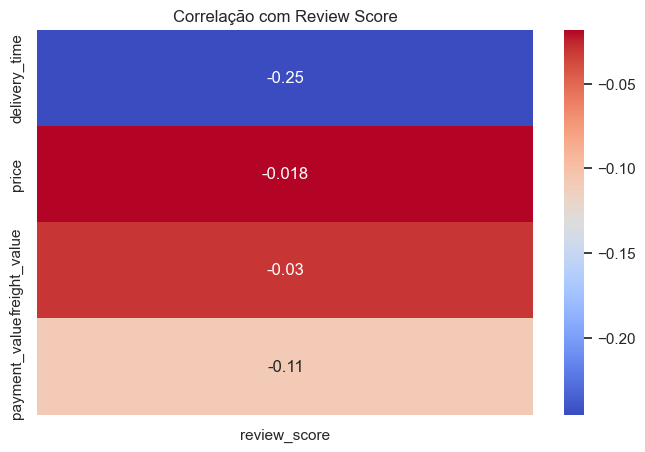

C:\Users\Marisa\AppData\Local\Temp\ipykernel_9348\1995061255.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delivery_group.index, y=delivery_group.values, palette='viridis')


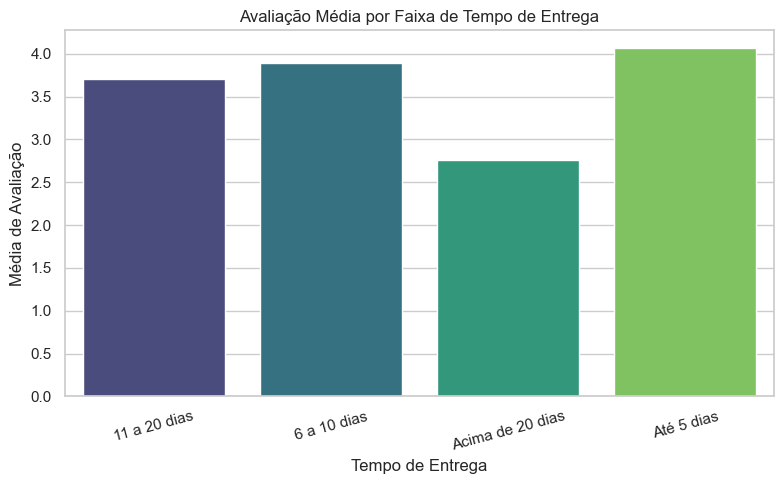

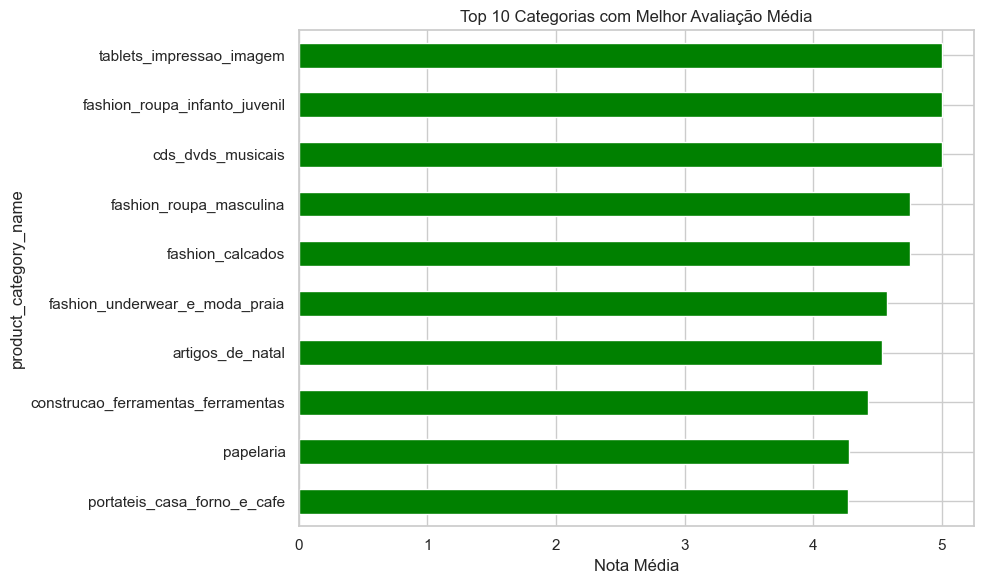

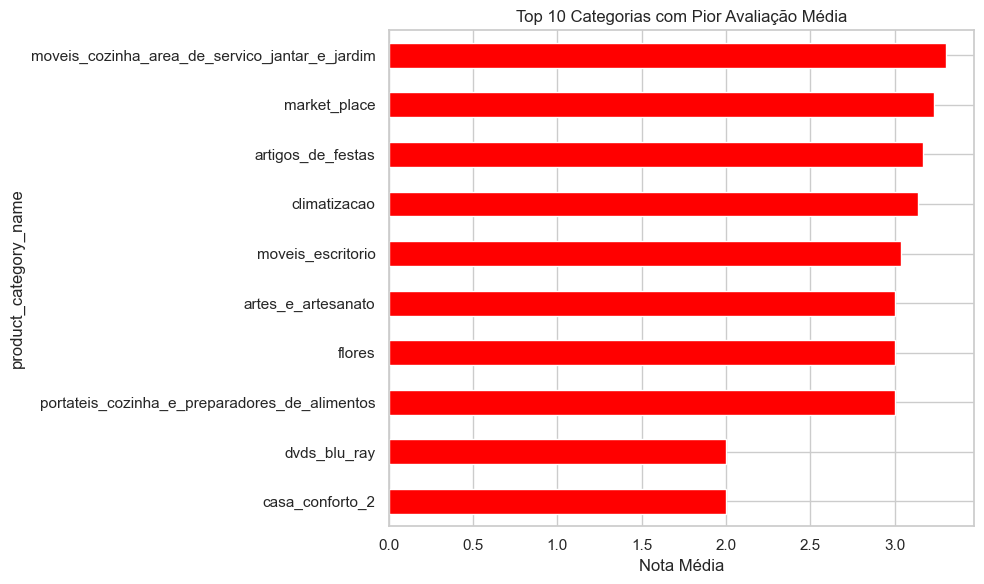

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carregando os dados
orders = pd.read_csv('data_limpa/olist_orders_dataset_limpa.csv')
reviews = pd.read_csv('data_limpa/olist_order_reviews_dataset_limpa.csv')
items = pd.read_csv('data_limpa/olist_order_items_dataset_limpa.csv')
products = pd.read_csv('data_limpa/olist_products_dataset_limpa.csv')
payments = pd.read_csv('data_limpa/olist_order_payments_dataset_limpa.csv')

# 2. Preparando os dados
# Tempo de entrega (dias)
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

# Unir dados
df = orders.merge(reviews[['order_id', 'review_score']], on='order_id') \
           .merge(items[['order_id', 'product_id', 'price', 'freight_value']], on='order_id') \
           .merge(products[['product_id', 'product_category_name']], on='product_id') \
           .merge(payments[['order_id', 'payment_value']], on='order_id')

# 3. Correlação entre review_score e variáveis numéricas
correlation = df[['review_score', 'delivery_time', 'price', 'freight_value', 'payment_value']].corr()
print("=== Correlação com review_score ===")
print(correlation['review_score'].sort_values(ascending=False))

# 4. Médias por categoria
category_avg = df.groupby('product_category_name')['review_score'].mean().sort_values(ascending=False)
print("\n=== Top 5 categorias com maiores médias de avaliação ===")
print(category_avg.head(5))

print("\n=== Top 5 categorias com menores médias de avaliação ===")
print(category_avg.tail(5))

# 5. Faixas de tempo de entrega vs média de avaliação
def delivery_range(days):
    if days <= 5:
        return 'Até 5 dias'
    elif days <= 10:
        return '6 a 10 dias'
    elif days <= 20:
        return '11 a 20 dias'
    else:
        return 'Acima de 20 dias'

df['delivery_range'] = df['delivery_time'].apply(delivery_range)
delivery_group = df.groupby('delivery_range')['review_score'].mean().sort_index()
print("\n=== Avaliação média por tempo de entrega ===")
print(delivery_group)

# 6. Visualizações
sns.set(style='whitegrid')

# Gráfico 1: Correlação visual
plt.figure(figsize=(8, 5))
sns.heatmap(correlation[['review_score']].drop('review_score'), annot=True, cmap='coolwarm')
plt.title("Correlação com Review Score")
plt.show()

# Gráfico 2: Avaliação por faixa de tempo de entrega
plt.figure(figsize=(8, 5))
sns.barplot(x=delivery_group.index, y=delivery_group.values, palette='viridis')
plt.title("Avaliação Média por Faixa de Tempo de Entrega")
plt.xlabel("Tempo de Entrega")
plt.ylabel("Média de Avaliação")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Gráfico 3: Top 10 categorias com melhores avaliações
plt.figure(figsize=(10, 6))
category_avg.head(10).plot(kind='barh', color='green')
plt.title("Top 10 Categorias com Melhor Avaliação Média")
plt.xlabel("Nota Média")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Gráfico 4: Top 10 categorias com piores avaliações
plt.figure(figsize=(10, 6))
category_avg.tail(10).plot(kind='barh', color='red')
plt.title("Top 10 Categorias com Pior Avaliação Média")
plt.xlabel("Nota Média")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Análise de Satisfação do Cliente

A análise de satisfação dos clientes foi realizada a partir da variável `review_score`, cruzando com diferentes fatores como tempo de entrega, valor do pedido, frete, e categoria de produto.

### Correlação com Avaliação (Review Score)

| Variável           | Correlação com `review_score` |
|--------------------|-------------------------------|
| `delivery_time`    | **-0.303**                    |
| `payment_value`    | -0.083                        |
| `freight_value`    | -0.038                        |
| `price`            | -0.005                        |

> **Interpretação:** A correlação mais forte é entre **tempo de entrega** e avaliação, com valor negativo de **-0.30**, indicando que **quanto maior o tempo de entrega, menor tende a ser a nota dada pelo cliente**. As demais variáveis possuem correlação muito fraca ou nula.

---

### Avaliação por Categoria de Produto

#### Top 5 categorias com maiores médias de avaliação:

| Categoria                          | Avaliação Média |
|------------------------------------|-----------------|
| cds_dvds_musicais                  | 4.64            |
| fashion_roupa_infanto_juvenil     | 4.50            |
| livros_interesse_geral            | 4.44            |
| flores                             | 4.42            |
| livros_importados                  | 4.42            |

#### Top 5 categorias com menores médias de avaliação:

| Categoria                                              | Avaliação Média |
|---------------------------------------------------------|-----------------|
| moveis_escritorio                                       | 3.53            |
| portateis_cozinha_e_preparadores_de_alimentos           | 3.27            |
| fraldas_higiene                                         | 3.26            |
| pc_gamer                                                | 3.10            |
| seguros_e_servicos                                      | 2.50            |

>  **Observação:** Categorias ligadas a **livros, flores e vestuário infantil** tendem a gerar maior satisfação. Já produtos de **alta complexidade ou serviço (ex: seguros)** mostram maior insatisfação.

---

###  Avaliação por Faixa de Tempo de Entrega

| Faixa de Entrega      | Avaliação Média |
|------------------------|-----------------|
| Até 5 dias             | 4.35            |
| 6 a 10 dias            | 4.26            |
| Acima de 20 dias       | **2.90**        |

>  **Conclusão:** Entregas feitas em **até 10 dias** mantêm a média de avaliação alta (acima de 4). Quando o prazo ultrapassa 20 dias, a satisfação **cai drasticamente** para menos de 3.

---

###  Conclusões e Recomendações

- **Tempo de entrega é o principal fator que impacta negativamente a avaliação.** Estratégias logísticas que reduzam o prazo devem ser prioridade.
- Produtos com menor satisfação (ex: móveis, eletrônicos complexos e serviços) devem ter **melhor suporte, informações mais claras e pós-venda eficiente**.
- Produtos de nicho com boa avaliação (livros, flores) podem ser **utilizados em campanhas promocionais** para reforçar a experiência positiva.
